In [165]:
%matplotlib inline
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
from scipy import signal
import peakutils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.vq import kmeans2,vq, whiten
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [154]:
from mpl_toolkits.mplot3d import Axes3D

In [8]:
(rate,sig) = wav.read("avp3-2.wav")
sig = sig[:, 0]
mfcc_feat = mfcc(sig, rate)
mfcc_feat.shape

(709, 13)

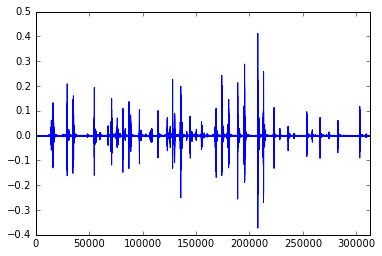

In [9]:
pd.Series(sig).plot()

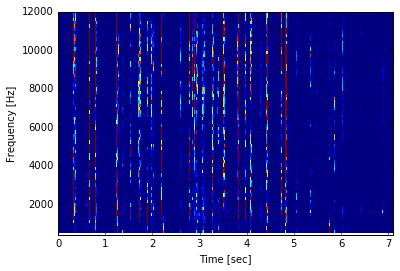

In [13]:
f, t, Sxx = signal.spectrogram(sig, rate)
# t -> X, time
# f -> Y, frequency in HZ
# Sxx -> C, actual values themselves

plt.pcolormesh(t, f[3:70], Sxx[3:70, :], norm=None, alpha=1, vmax=1e-8, vmin=0)
plt.ylabel('Frequency [Hz]')
plt.ylim((400, 12000))
plt.xlim(0, 7.1)
plt.xlabel('Time [sec]')
plt.show()

In [57]:
s = "avpavpavpaaavvvppp"
sig_str = np.sum(Sxx[3:70, :], axis=0)
indexes = peakutils.indexes(sig_str, thres=0.132, min_dist=5)
print indexes
len(indexes), len(s)

[  72  132  157  245  317  364  433  572  580  606  754  777  806  843  872
  927  951 1132]


(18, 18)

(0, 5)

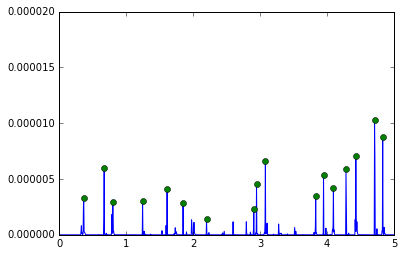

In [58]:
plt.plot(t, sig_str)
plt.plot(t[indexes], sig_str[indexes], 'o')
plt.ylim(0, 2e-5)
plt.xlim(0, 5)

(0, 5)

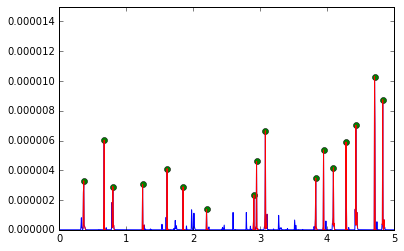

In [101]:
# fig = plt.figure(figsize=(18, 18))
plt.plot(t, sig_str)
plt.plot(t[indexes], sig_str[indexes], 'o')

keystroke_feats = []
wave_len = 0.04
for i in range(len(indexes)):
    ind = indexes[i]
    plt.plot(t[ind - 2: ind + 6], sig_str[ind - 2: ind + 6], 'r')
    # Take exactly 40 ms
    key_start = int(t[ind - 2] * rate)
    key_end = int(key_start + wave_len * rate)
    keypress_sig = sig[key_start:key_end]
    mfcc_feat = mfcc(keypress_sig, rate, winlen=0.01, 
    winstep=0.0025, numcep=16, nfilt=32, 
    lowfreq=400, highfreq=12000)
    keystroke_feats.append(np.concatenate(mfcc_feat[2:7, :]).T)
data = np.vstack(keystroke_feats)
data.shape
plt.ylim(0, 1.5e-5)
plt.xlim(0, 5)

In [179]:
data_w = whiten(data)
kmeans = KMeans(n_clusters=3).fit(data_w)
kmeans.labels_

array([0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1], dtype=int32)

[ 0.21406943  0.12663379]
[2 0 2 2 1 0 2 2 0 2 2 1 2 0 0 0 0 2]


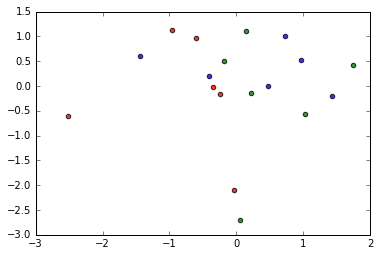

In [180]:
clusters = 3
pca = PCA(n_components=2)
data_t = pca.fit_transform(data)
print(pca.explained_variance_ratio_) 
data_w = whiten(data_t)
centroids, labels = kmeans2(data_w, clusters)
print labels

a = data_w[[0, 3, 6, 9, 10, 11]]
p = data_w[[1, 4, 7, 12, 13, 14]]
v = data_w[[2, 5, 8, 15, 16, 17]]

plt.scatter([x[0] for x in a], [x[1] for x in a], c='r', alpha=0.8)
plt.scatter([x[0] for x in p], [x[1] for x in p], c='g', alpha=0.8)
plt.scatter([x[0] for x in v], [x[1] for x in v], c='b', alpha=0.8)

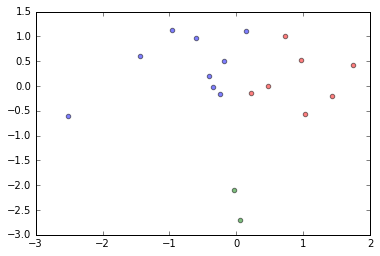

In [181]:
# Actual clusters
plt.scatter([x[0] for x in data_w[labels==0]], [x[1] for x in data_w[labels==0]], c='r', alpha=0.5)
plt.scatter([x[0] for x in data_w[labels==1]], [x[1] for x in data_w[labels==1]], c='g', alpha=0.5)
plt.scatter([x[0] for x in data_w[labels==2]], [x[1] for x in data_w[labels==2]], c='b', alpha=0.5)

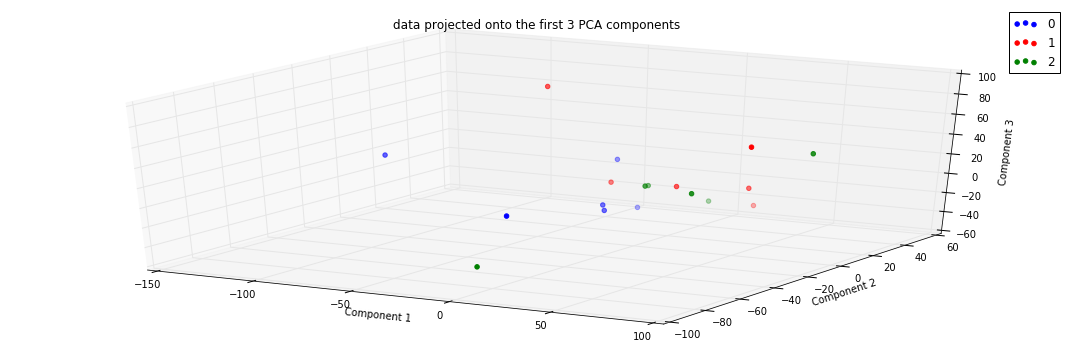

In [182]:
#Apply PCA to data and get the top 3 axes of maximum variation
pca = PCA(n_components=3)
pca.fit(data)

#Project to the data onto the three axes
x_reduced = pca.transform(data)
a = x_reduced[[0, 3, 6, 9, 10, 11]]
p = x_reduced[[1, 4, 7, 12, 13, 14]]
v = x_reduced[[2, 5, 8, 15, 16, 17]]

#Visualized our reduced data
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.scatter([x[0] for x in a], [x[1] for x in a], [x[2] for x in a], color='b', label='0')
ax1.scatter([x[0] for x in v], [x[1] for x in v], [x[2] for x in v], c='r', color='r', label='1')
ax1.scatter([x[0] for x in p], [x[1] for x in p], [x[2] for x in p], c='g', color='g', label='2')

ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.set_zlabel('Component 3')
ax1.set_title('data projected onto the first 3 PCA components')
ax1.legend()

plt.tight_layout()
plt.show()